In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

### Define file directories

In [2]:
input_path = "./data/input_data" 
temp_path = "./data/temp_data"
output_path = "./data/output_data"

### Define file paths

define the naming used for each file, be it input, output or intermediary files.

In [3]:
output_era5_file_name = "era5-ethiopia"
output_ecmwf_file_name = "ecmwf-ethiopia"

admin_file_name = "admin_boundary_eth/eth_admbnda_adm1_csa_bofedb_2021.shp"
admin_code_label = "ADM1_PCODE"
    
#input datasets
admin_boundary_file_path = f"{input_path}/{admin_file_name}"

#ECMWF intermediary datasets
ecmwf_processed_pixel_file_path = f"{temp_path}/{output_ecmwf_file_name}-processed-pixel.parquet.gzip"
ecmwf_processed_adm_file_path = f"{temp_path}/{output_ecmwf_file_name}-processed-adm.parquet.gzip"
ecmwf_bias_corr_pixel_file_path = f"{temp_path}/{output_ecmwf_file_name}-bias-corrected-pixel.parquet.gzip"
ecmwf_bias_corr_adm_file_path = f"{temp_path}/{output_ecmwf_file_name}-bias-corrected-adm.parquet.gzip"
ref_grid_file_path = f"{temp_path}/{output_ecmwf_file_name}-reference-grid.parquet.gzip"

#ERA5 intermediary/export datasets
era5_processed_pixel_file_path = f"{output_path}/{output_era5_file_name}-processed-pixel.parquet.gzip"
era5_processed_adm_file_path = f"{output_path}/{output_era5_file_name}-processed-adm.parquet.gzip"

#ECMWF export datasets
ecmwf_quantile_pixel_file_path = f"{output_path}/{output_ecmwf_file_name}-quantile-pixel.parquet.gzip"
ecmwf_quantile_bias_corr_pixel_file_path = f"{output_path}/{output_ecmwf_file_name}-quantile-bias-corrected-pixel.parquet.gzip"
ecmwf_quantile_adm_file_path = f"{output_path}/{output_ecmwf_file_name}-quantile-adm.parquet.gzip"
ecmwf_quantile_bias_corr_adm_file_path = f"{output_path}/{output_ecmwf_file_name}-quantile-bias-corrected-adm.parquet.gzip"

## Plot Functions

In [4]:
def plot_climatology(ecmwf_df, ecmwf_corr_df, scope_text):
    era5_month_df = ecmwf_df.groupby('valid_time_month')['tp_mm_day_era5'].mean().reset_index()  
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))
    row = 0
    for col in range(2):

        ax = axs[col]
        
        if col == 0:
            bias_text = 'Before bias correction'
            ecmwf_month_df = ecmwf_df.groupby(['lead_time','valid_time_month'])['tp_mm_day'].mean().reset_index()
        else:
            bias_text = 'After bias correction'
            ecmwf_month_df = ecmwf_corr_df.groupby(['lead_time','valid_time_month'])['tp_mm_day'].mean().reset_index()
        
        ax.plot(era5_month_df['valid_time_month'],era5_month_df['tp_mm_day_era5'], label = 'era5')
        for i in range(1,7):
            ecmwf_month_df_plot = ecmwf_month_df[ecmwf_month_df['lead_time'] == i]
            ax.plot(ecmwf_month_df_plot['valid_time_month'],ecmwf_month_df_plot['tp_mm_day'], label = 'lead_time: ' + str(i))
        
        ax.set_title('Precipitation bias per month and lead time (' + scope_text +') \n ' + bias_text)
        ax.set_xlabel("month")
        ax.set_ylabel("precipitation bias (mm / day)")
        
        ax.legend(loc='best')

In [5]:
def plot_leadtime_month_dependency(ecmwf_df, ecmwf_corr_df, month_range, scope_text):
    plot_df = ecmwf_df[(ecmwf_df.climatology_q50 > 0) & (ecmwf_df['valid_time_month'].isin(month_range))]
    plot_df = plot_df.groupby(['lead_time','valid_time_month'])[['bias','mae']].mean().reset_index()
    plot_df = plot_df.groupby('lead_time')[['bias','mae']].mean().reset_index()
    
    plot_corr_df = ecmwf_corr_df[(ecmwf_corr_df.climatology_q50 > 0) & (ecmwf_corr_df['valid_time_month'].isin(month_range))] 
    plot_corr_df = plot_corr_df.groupby(['lead_time','valid_time_month'])[['bias','mae']].mean().reset_index()
    plot_corr_df = plot_corr_df.groupby('lead_time')[['bias','mae']].mean().reset_index()

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

    row = 0
    for col in range(2):     

        ax = axs[col]
        
        if col == 0:
            ax.plot(plot_df['lead_time'],plot_df.bias, label = 'Before bias correction')
            ax.plot(plot_corr_df['lead_time'],plot_corr_df.bias, label = 'After bias correction')
            ax.set_title('Bias evolution with lead time (' + scope_text +')')
            ax.set_ylabel("Bias (mm/day)")
            ax.set_ylim([
                min(-0.1, 1.1*plot_df.bias.min(), 1.1*plot_corr_df.bias.min()),
                max(0.1, 1.1*plot_df.bias.max(), 1.1*plot_corr_df.bias.max())
            ])
        else:
            ax.plot(plot_df['lead_time'],plot_df.mae, label = 'Before bias correction')
            ax.plot(plot_corr_df['lead_time'],plot_corr_df.mae, label = 'After bias correction')
            ax.set_title('MAE evolution with lead time (' + scope_text +')')
            ax.set_ylabel("MAE (mm/day)")
            ax.set_ylim([-0.1,max(1.1*plot_df.mae.max(),1.1*plot_corr_df.mae.max())])
                                     
        
        ax.set_xlabel('lead time')
        ax.legend(loc='best')

In [6]:
def plot_roc_auc_analysis(ecmwf_df, ecmwf_corr_df, quantile_value):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))
    
    q = str(quantile_value)
    auc_before_bias = []
    auc_after_bias = []
    lead_time = [1,2,3,4,5,6]

    for row in range(2):
        for col in range(2):
            ax = axs[row, col]
            if row == 0:
                if col == 0:
                    df = ecmwf_df.copy()
                    title_text = 'ROC before bias correction'
                elif col == 1:
                    df = ecmwf_corr_df.copy()
                    title_text = 'ROC after bias correction' 
                    
                plot_df = df[df['lead_time'] == 1]
                fpr, tpr, thresholds = metrics.roc_curve(plot_df['prob_q'+q+'_era5'], plot_df['prob_q'+q])
                ax.plot(fpr,fpr, label = 'no skill baseline')
                
                for i in df['lead_time'].unique():
                    plot_df = df[df['lead_time'] == i]
                    fpr, tpr, thresholds = metrics.roc_curve(plot_df['prob_q'+q+'_era5'], plot_df['prob_q'+q])
                    ax.plot(fpr,tpr, label = 'lead_time: ' + str(i))
                    if col == 0:
                        auc_before_bias.append(metrics.auc(fpr,tpr))
                    else:
                        auc_after_bias.append(metrics.auc(fpr,tpr))

            elif (row == 1 and col == 0):   
                title_text = 'ROC before/after bias correction for lead_time = 1'
                
                plot_df = ecmwf_df[ecmwf_df['lead_time'] == 1]
                fpr, tpr, thresholds = metrics.roc_curve(plot_df['prob_q'+q+'_era5'], plot_df['prob_q'+q])
                ax.plot(fpr,fpr, label = 'no skill baseline')
                
                ax.plot(fpr,tpr, label = 'Before bias correction')
                
                plot_df = ecmwf_corr_df[ecmwf_corr_df['lead_time'] == 1]
                fpr, tpr, thresholds = metrics.roc_curve(plot_df['prob_q'+q+'_era5'], plot_df['prob_q'+q])
                ax.plot(fpr,tpr, label = 'After bias correction')

            elif (row == 1 and col == 1):  
                title_text = 'Area Under the Curve (AUC) per lead time'
                ax.plot([1,6],[0.5,0.5], label = 'no skill baseline')
                ax.plot(lead_time,auc_before_bias, label = 'Before bias correction')
                ax.plot(lead_time,auc_after_bias, label = 'After bias correction')

            ax.legend(loc='best')
            ax.set_title(title_text)
                
            if (row == 1 and col == 1): 
                ax.set_ylabel('AUC')
                ax.set_xlabel('lead time')
                ax.set_ylim([0,1])
            else:
                ax.set_ylabel('True Positive Rate')
                ax.set_xlabel('False Positive Rate')

## Load Data

In [7]:
era5_pixel_df = pd.read_parquet(era5_processed_pixel_file_path)
era5_adm_df = pd.read_parquet(era5_processed_adm_file_path)

ecmwf_pixel_df = pd.read_parquet(ecmwf_quantile_pixel_file_path)
ecmwf_adm_df = pd.read_parquet(ecmwf_quantile_adm_file_path)
ecmwf_corr_pixel_df = pd.read_parquet(ecmwf_quantile_bias_corr_pixel_file_path)
ecmwf_corr_adm_df = pd.read_parquet(ecmwf_quantile_bias_corr_adm_file_path)

## Precipitation Bias

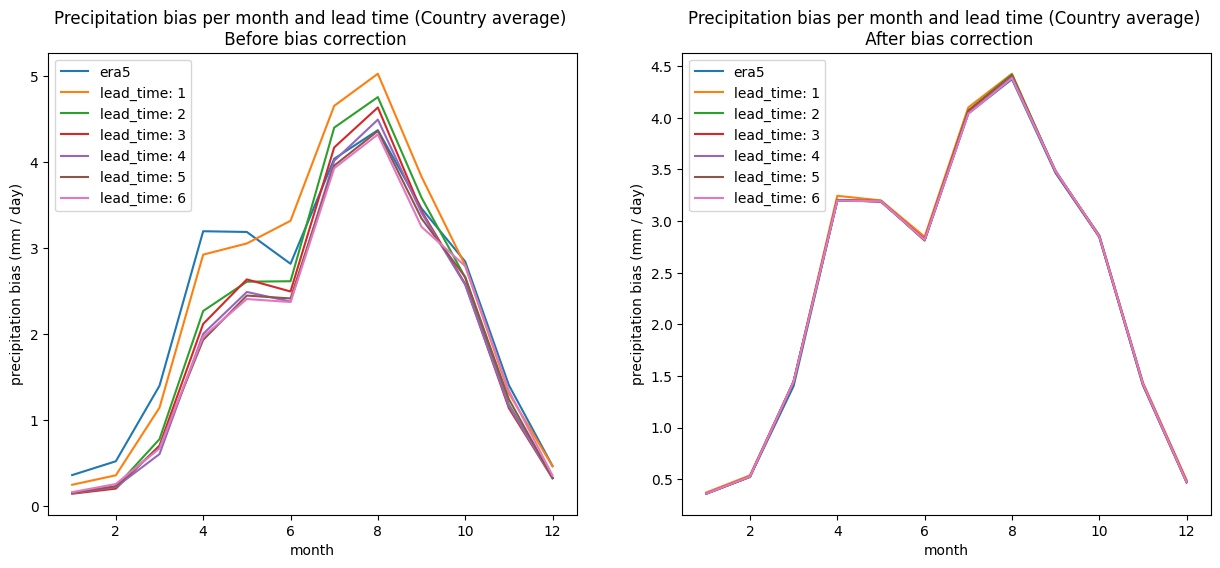

In [8]:
plot_climatology(ecmwf_pixel_df, ecmwf_corr_pixel_df, scope_text = 'Country average')

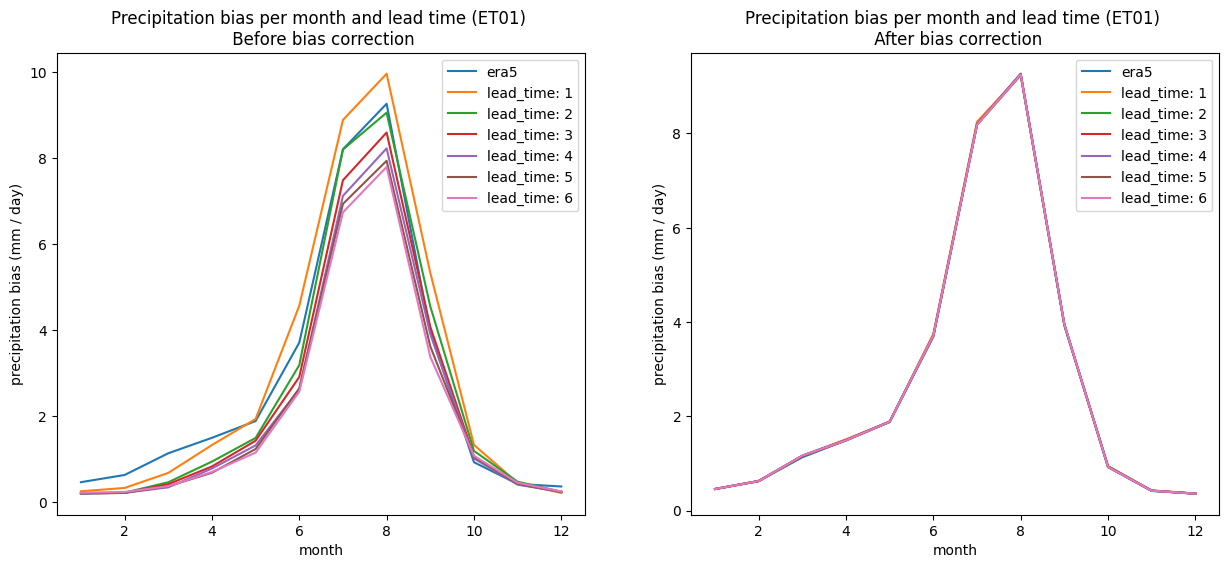

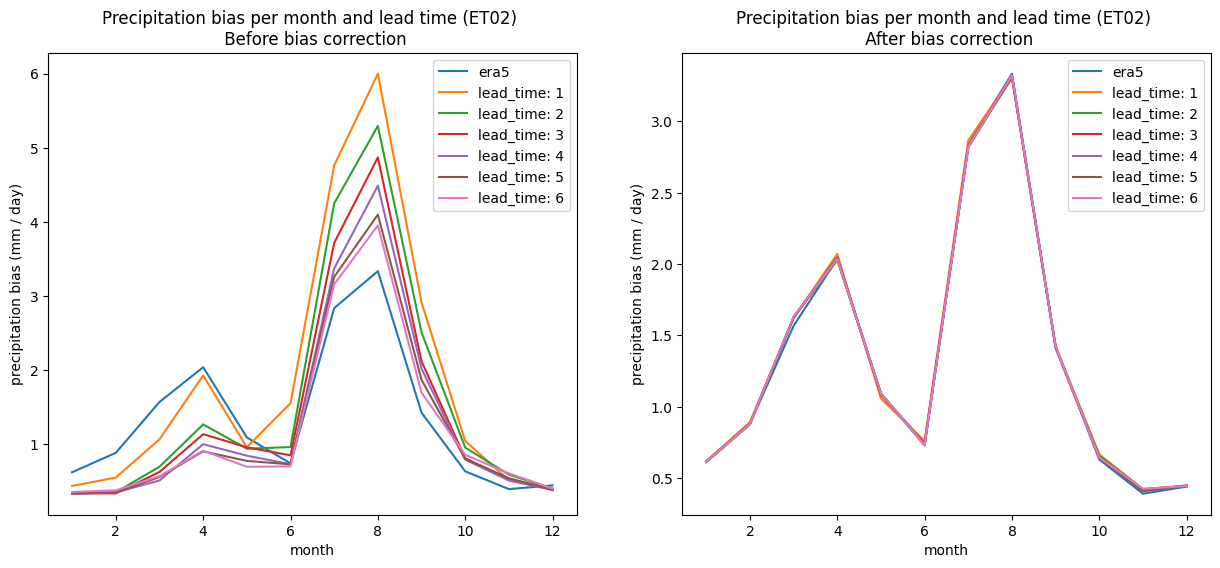

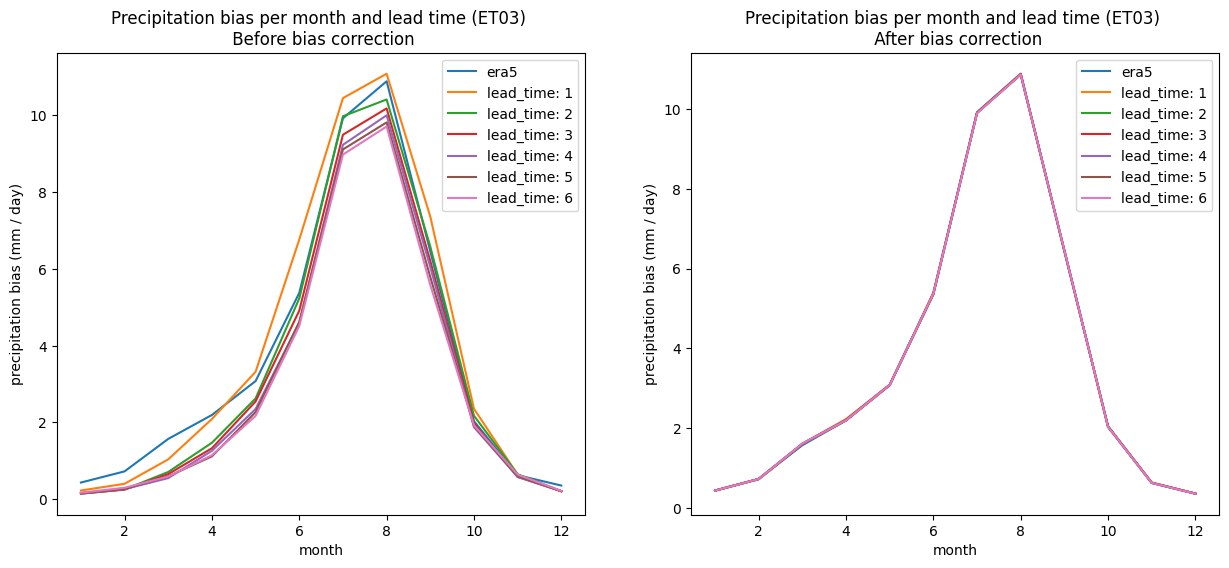

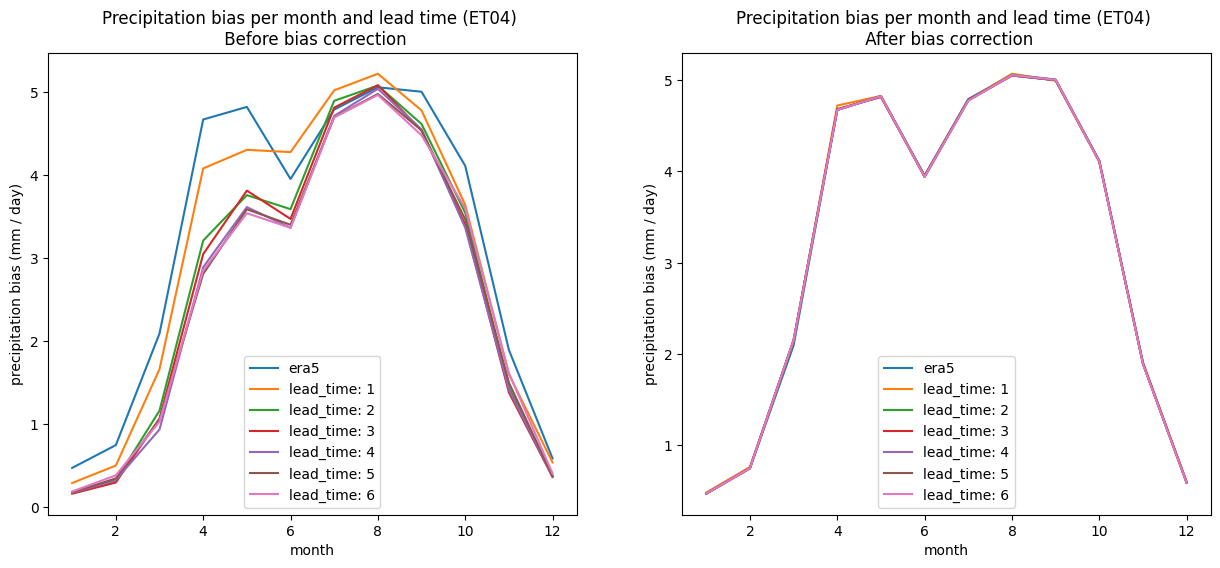

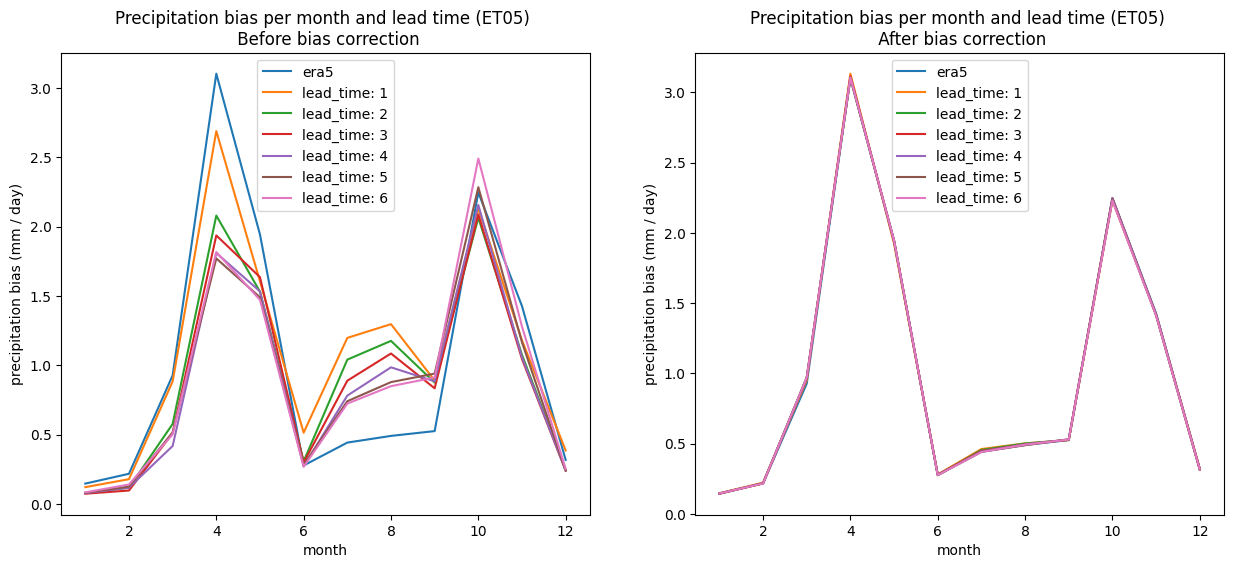

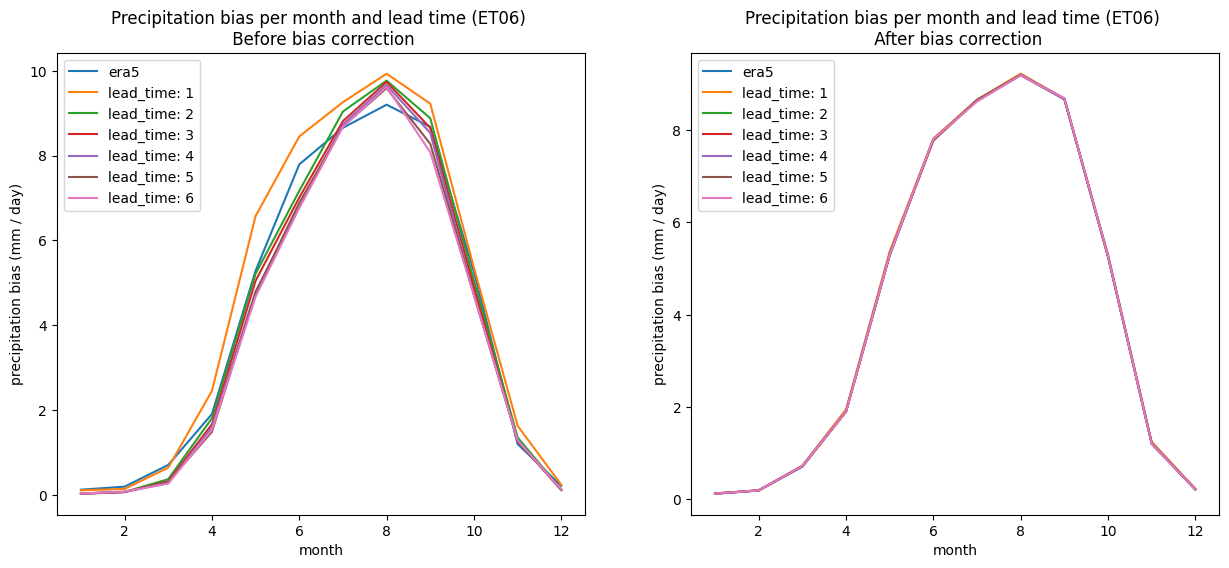

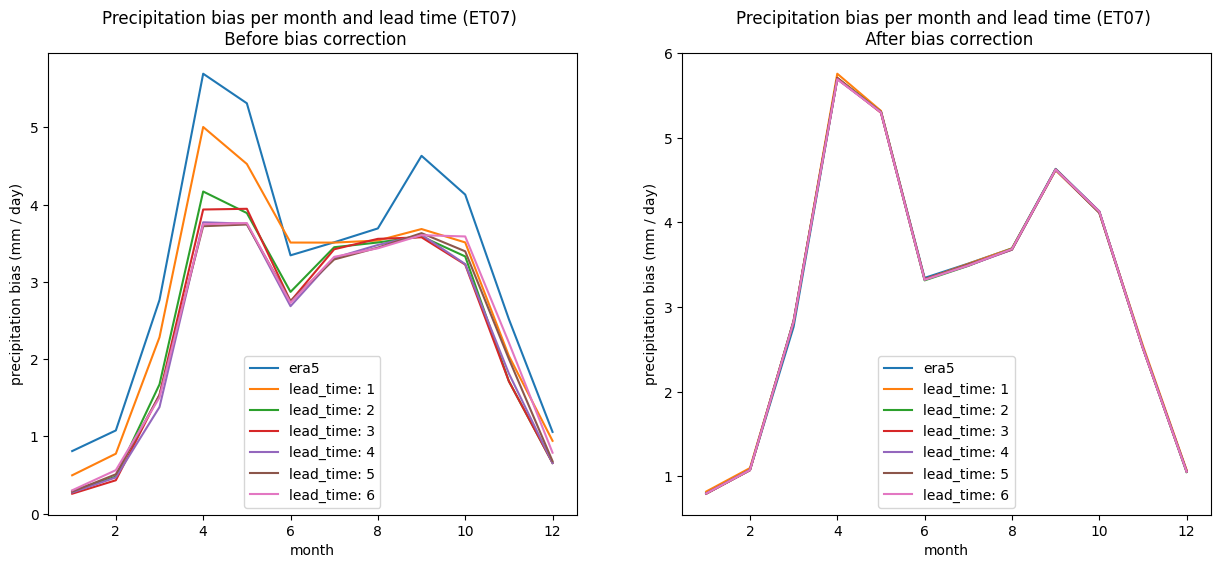

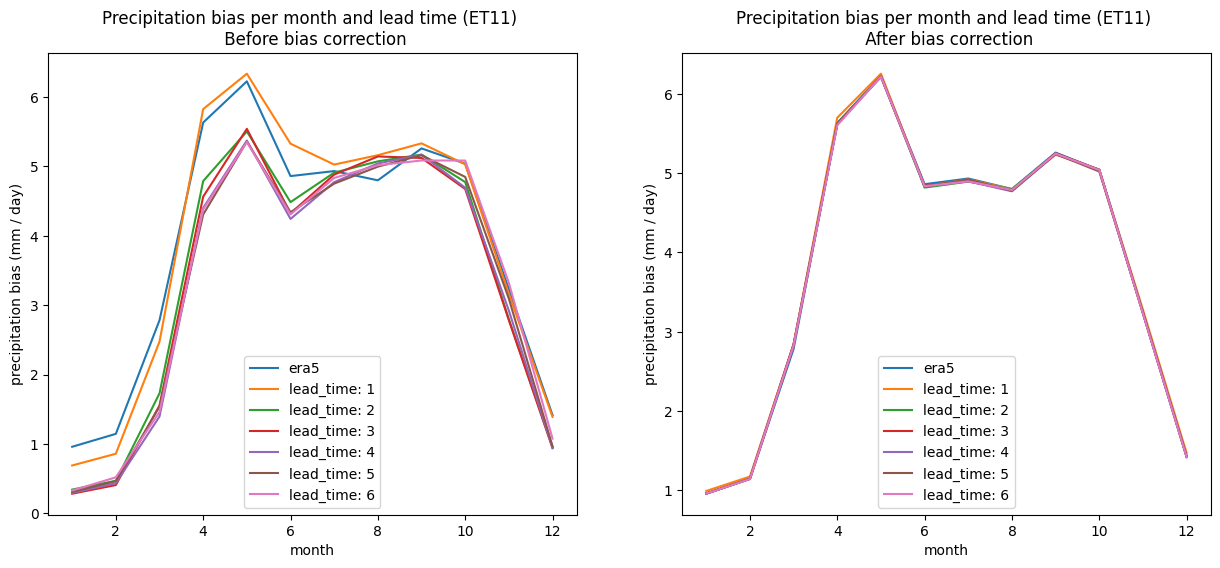

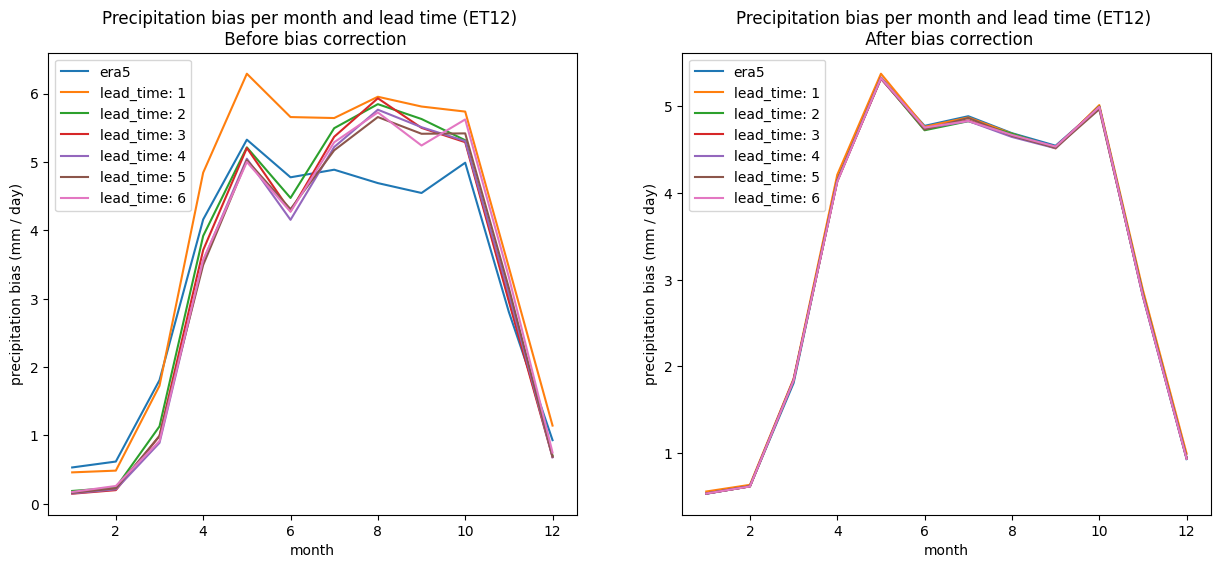

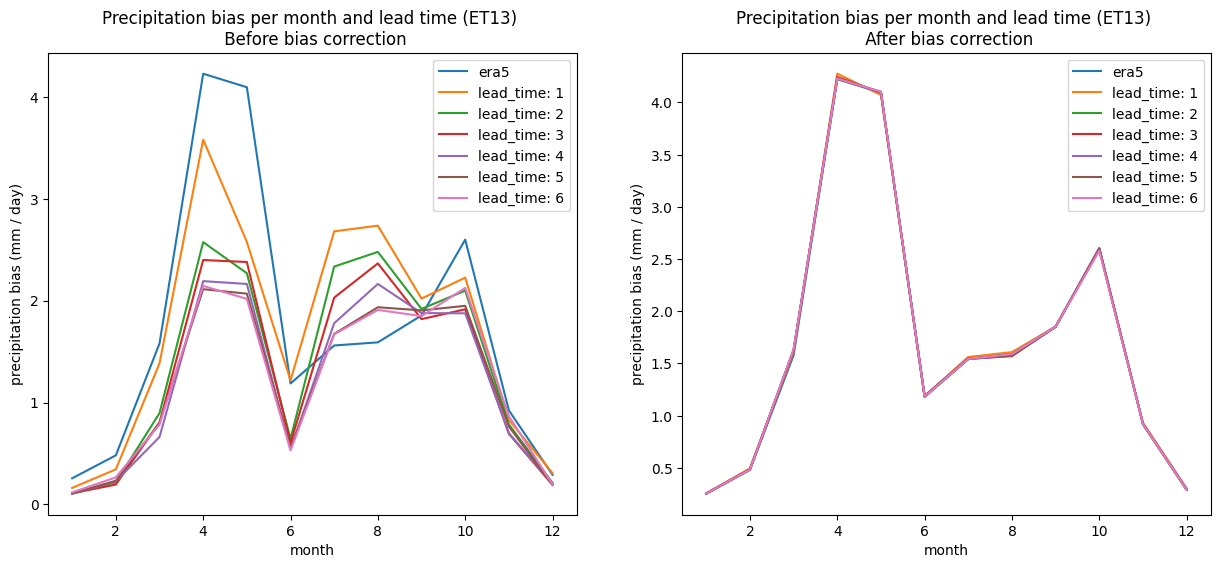

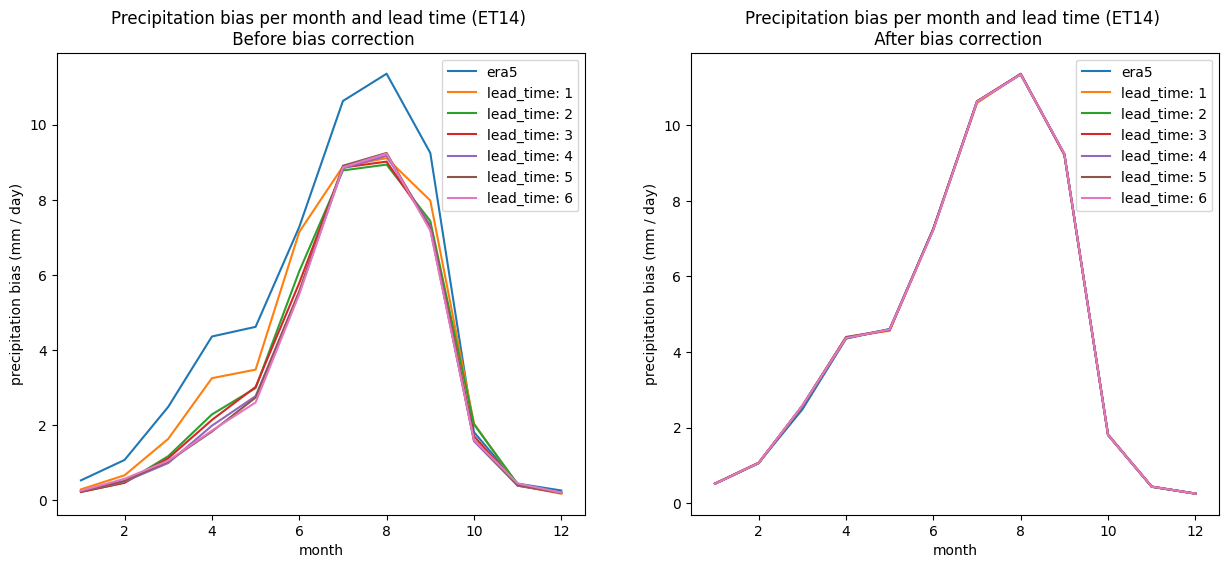

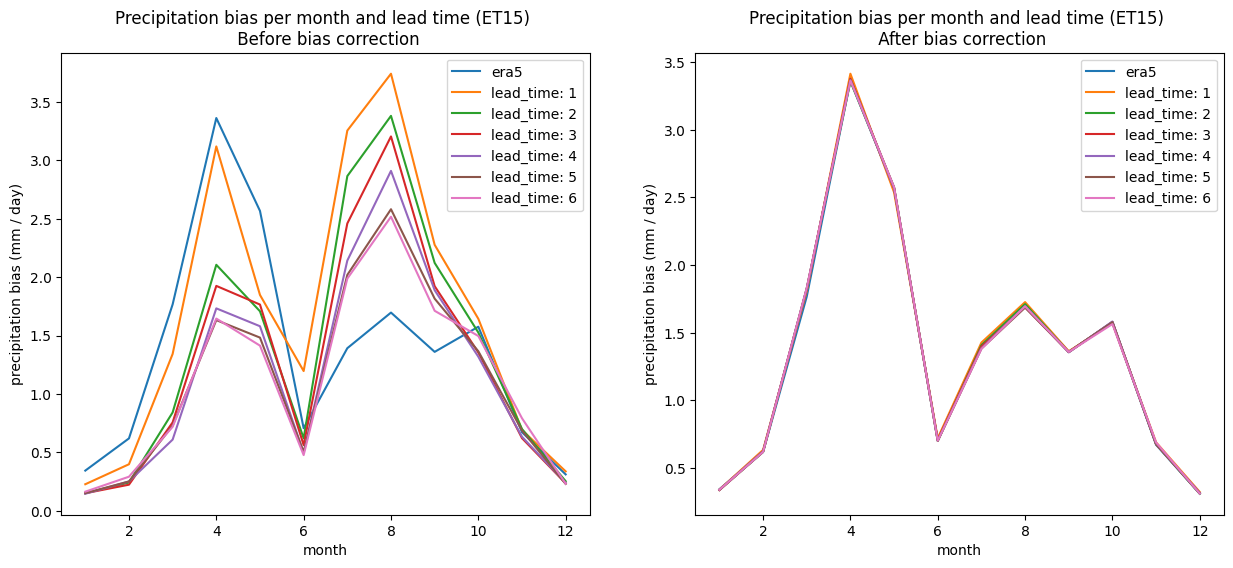

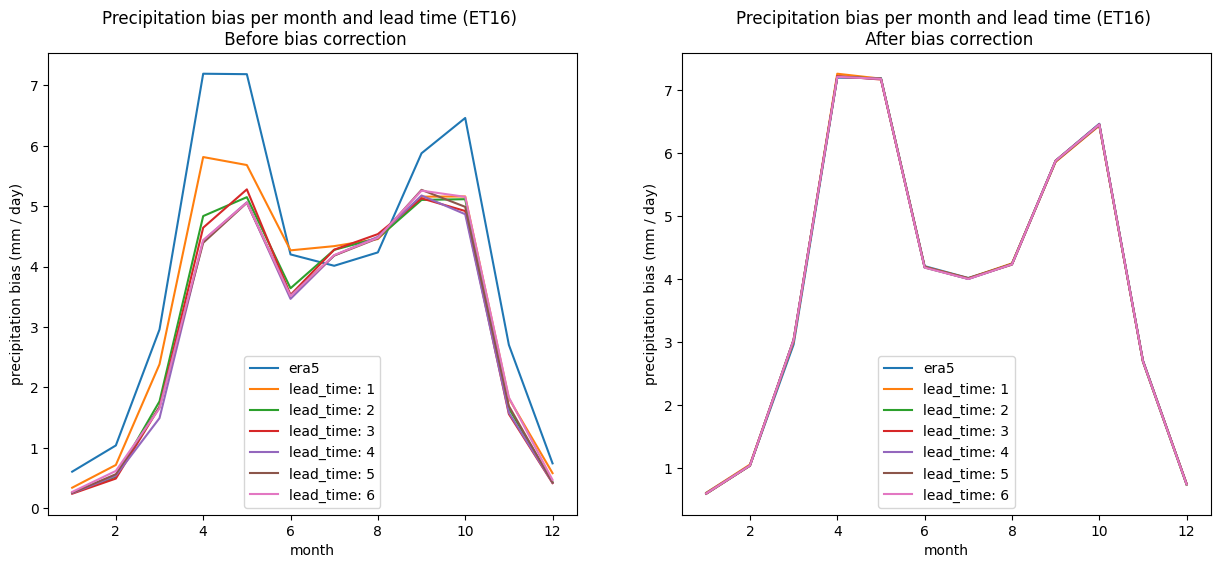

In [9]:
for adm_pcode in ecmwf_adm_df['adm_pcode'].unique():
    plot_climatology(
        ecmwf_adm_df[ecmwf_adm_df['adm_pcode'] == adm_pcode],
        ecmwf_corr_adm_df[ecmwf_corr_adm_df['adm_pcode'] == adm_pcode],
        scope_text = adm_pcode
)

## Leadtime Dependency

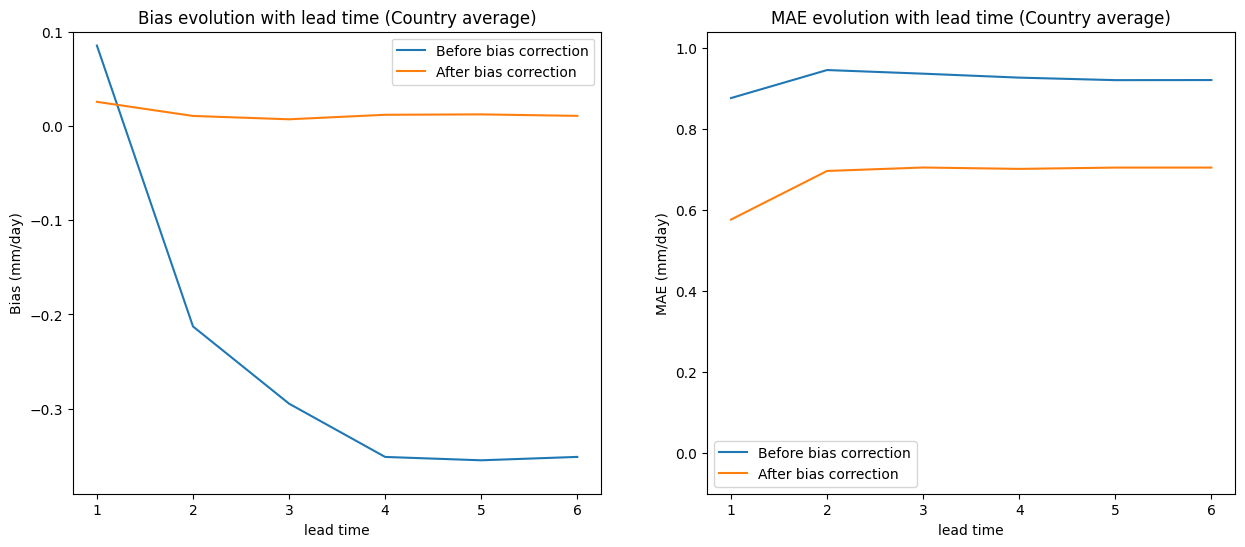

In [10]:
#month_range = [7,8,9]
month_range = [1,2,3,4,5,6,7,8,9,10,11,12]
plot_leadtime_month_dependency(ecmwf_pixel_df, ecmwf_corr_pixel_df, month_range, scope_text = 'Country average')

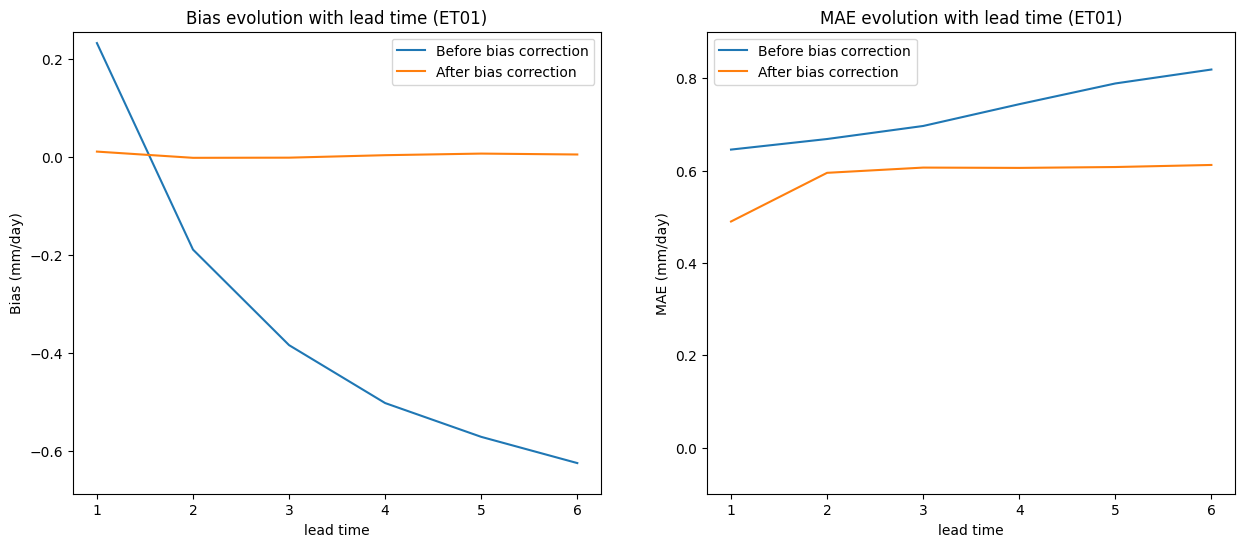

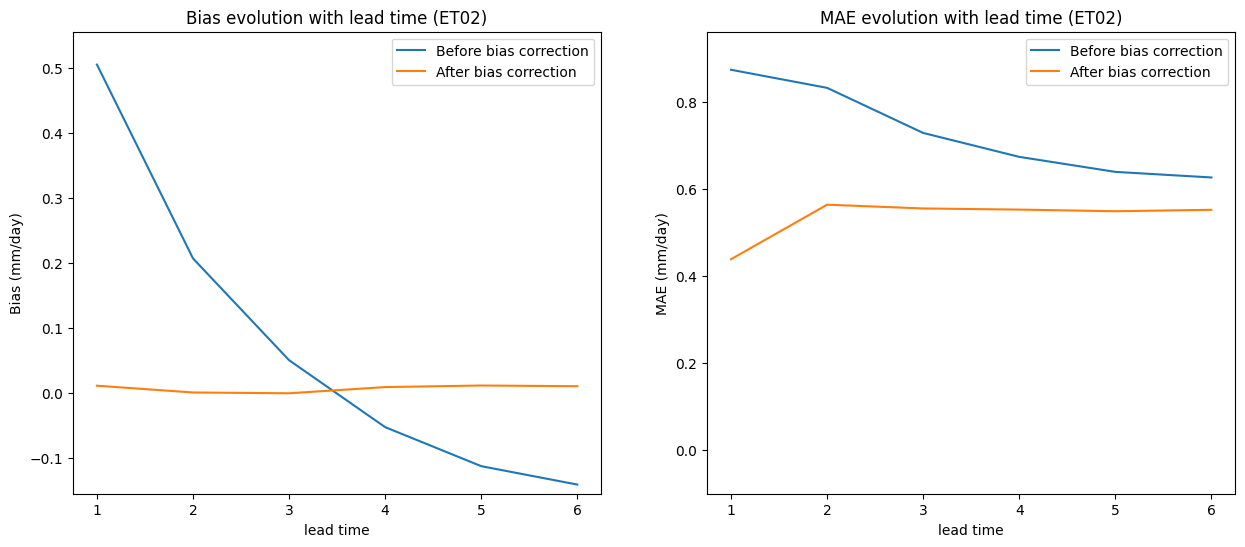

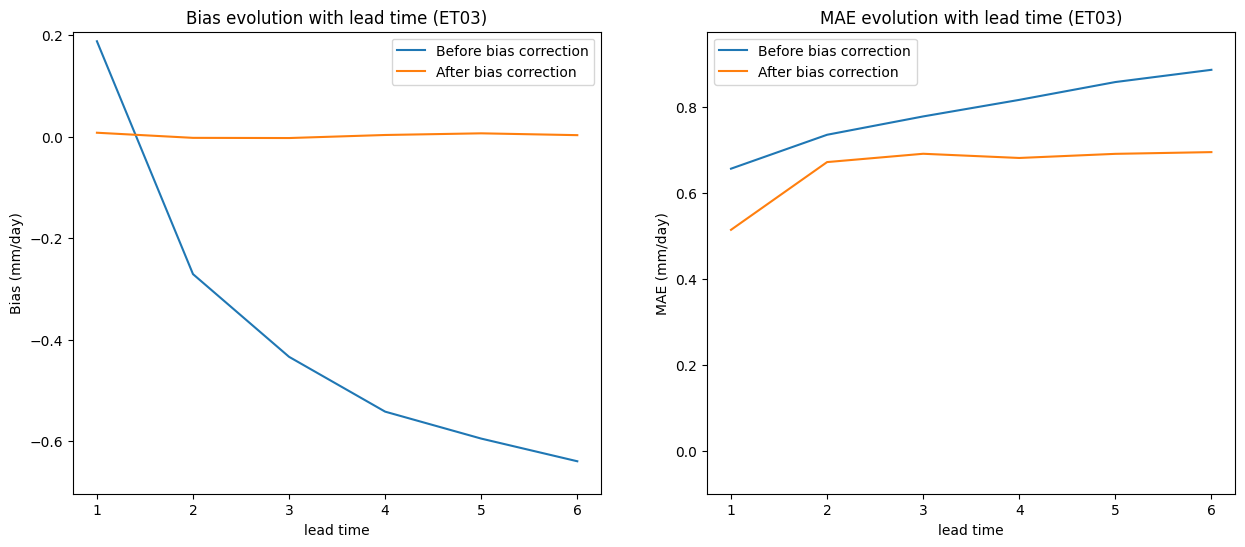

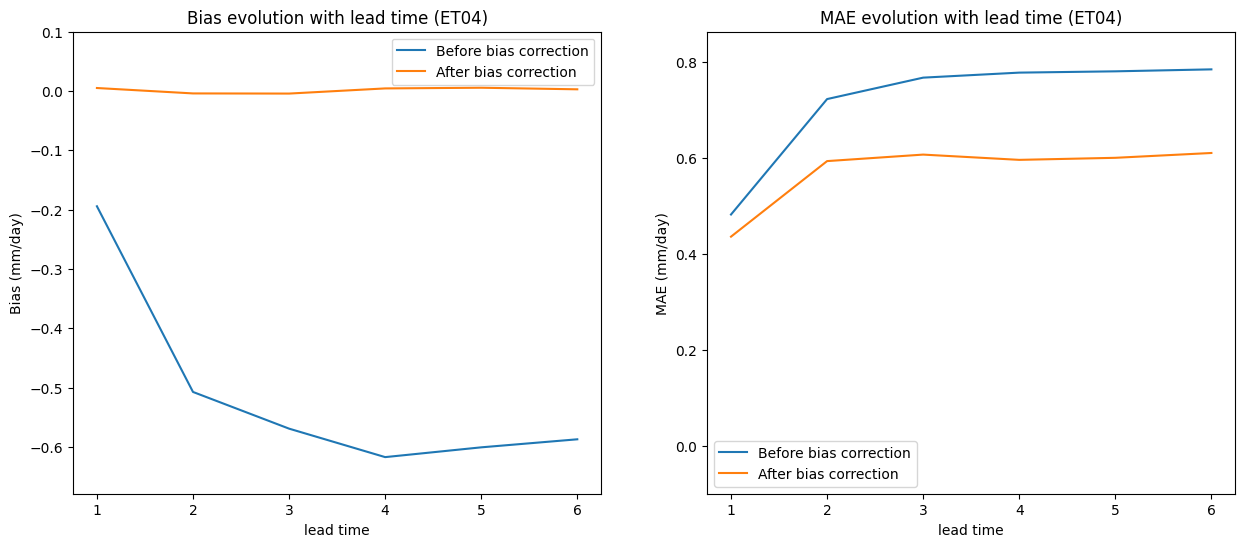

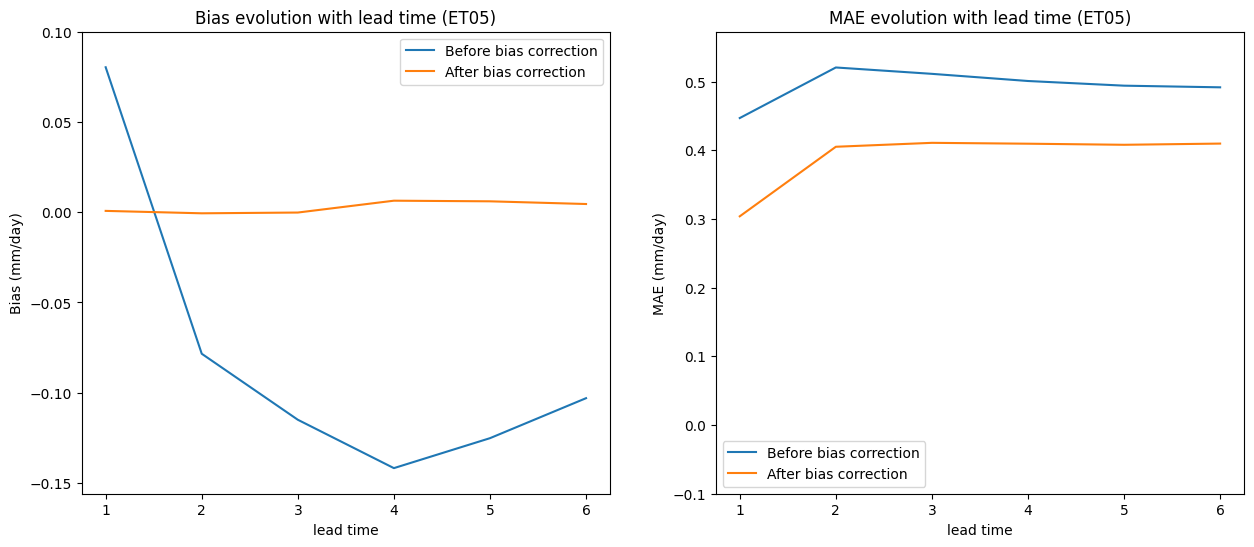

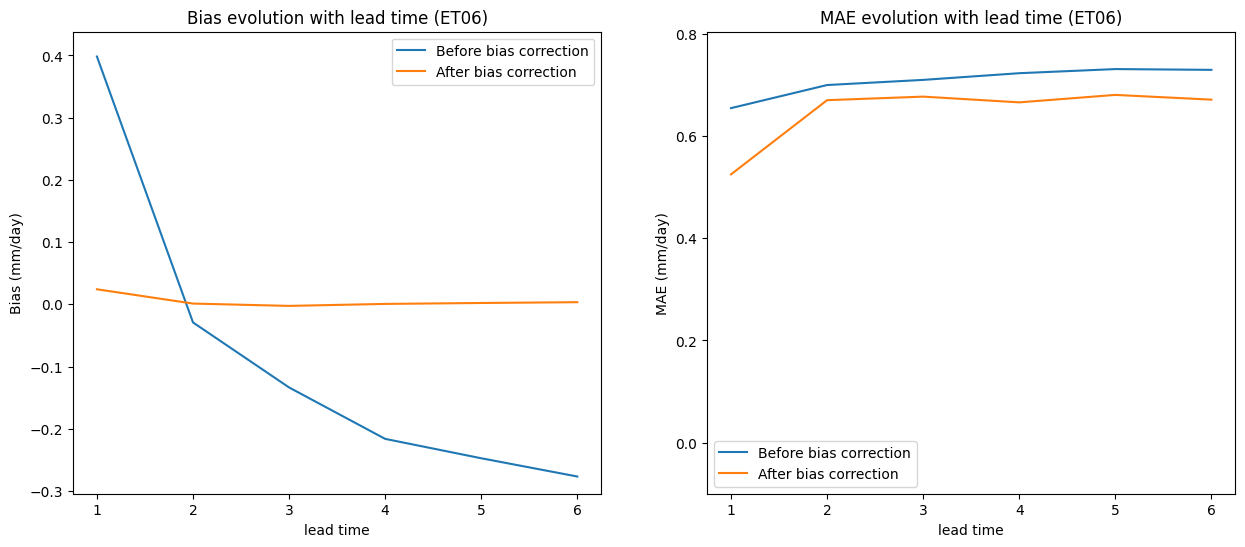

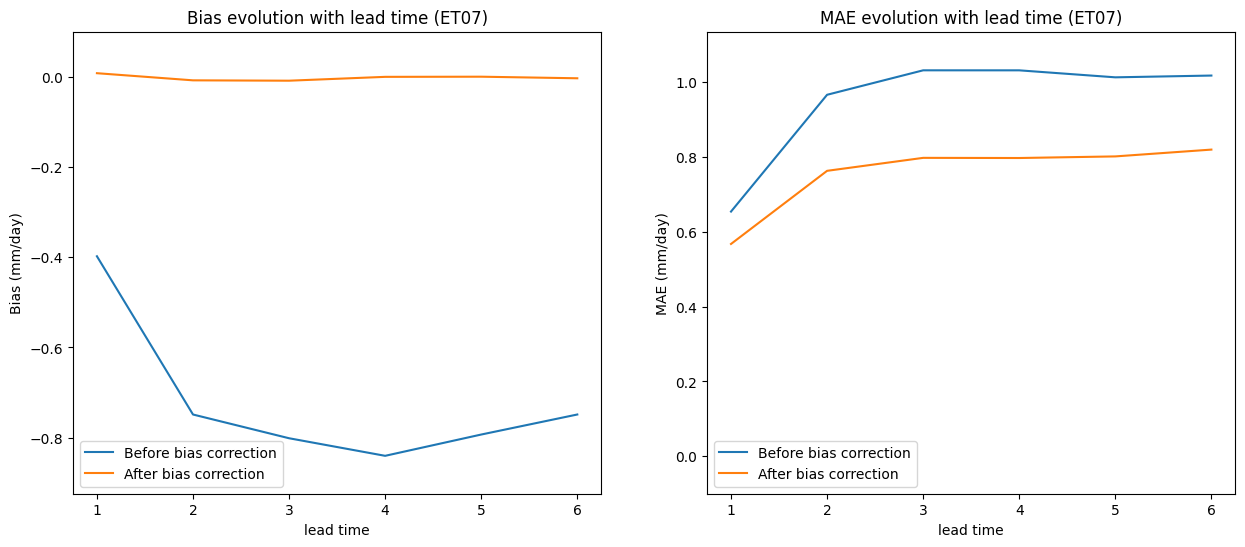

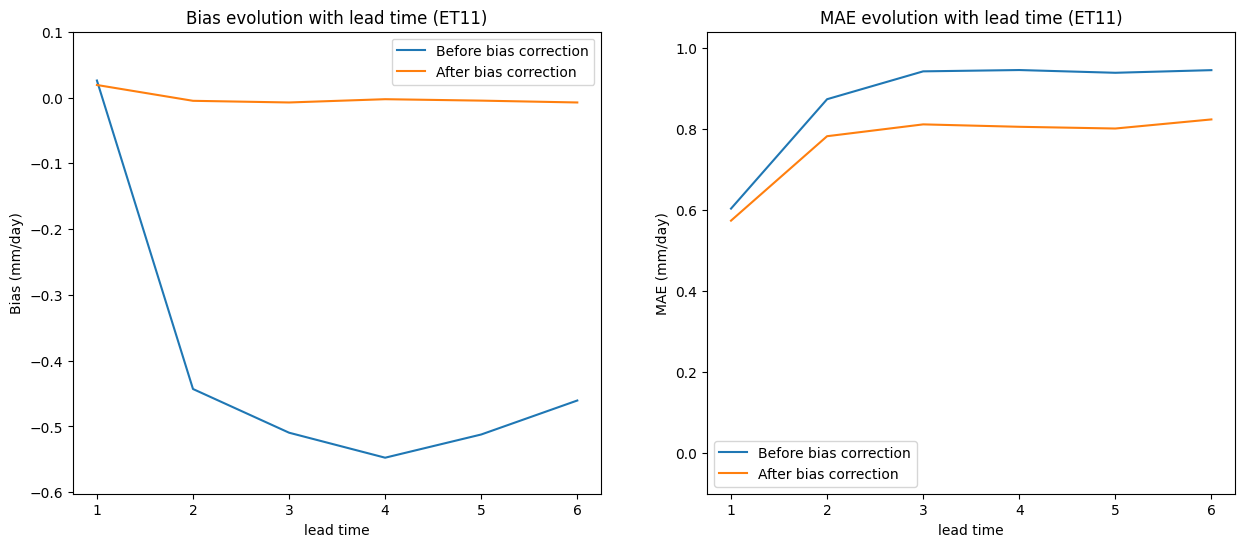

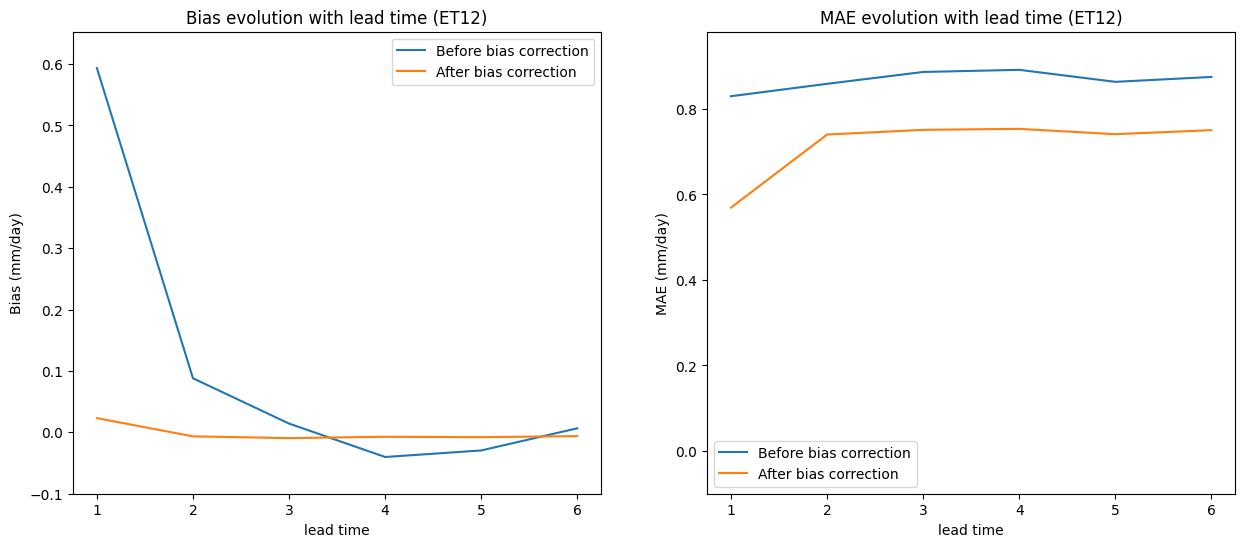

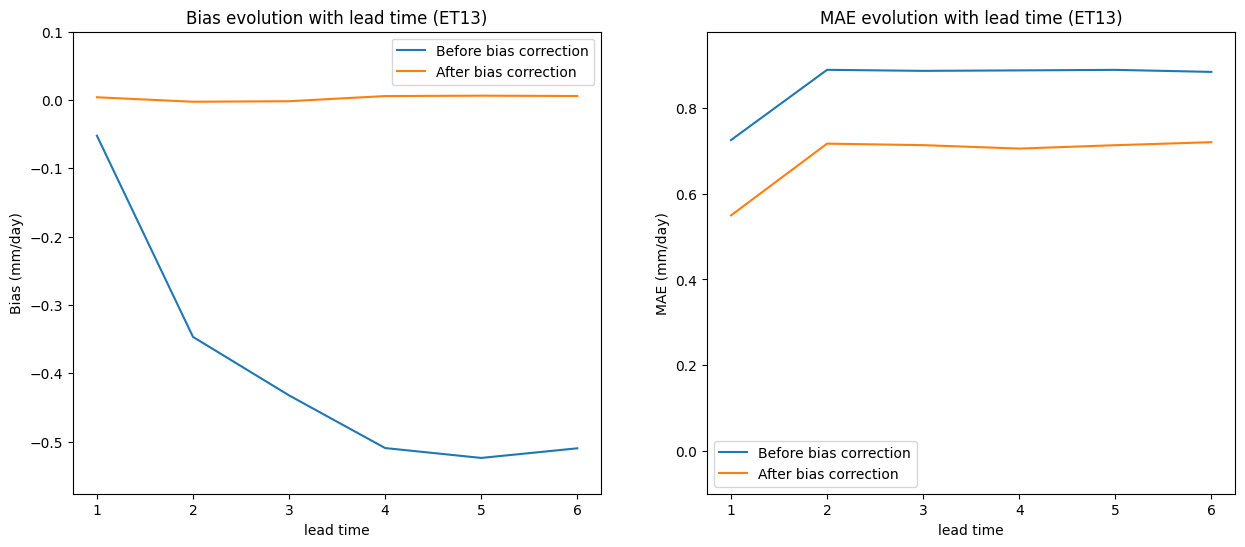

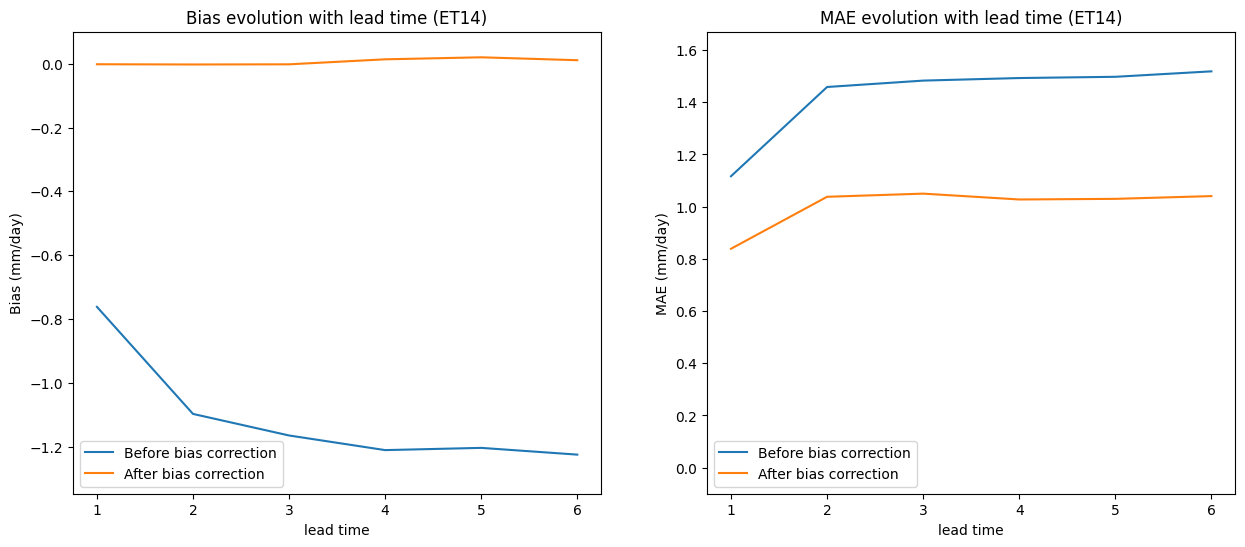

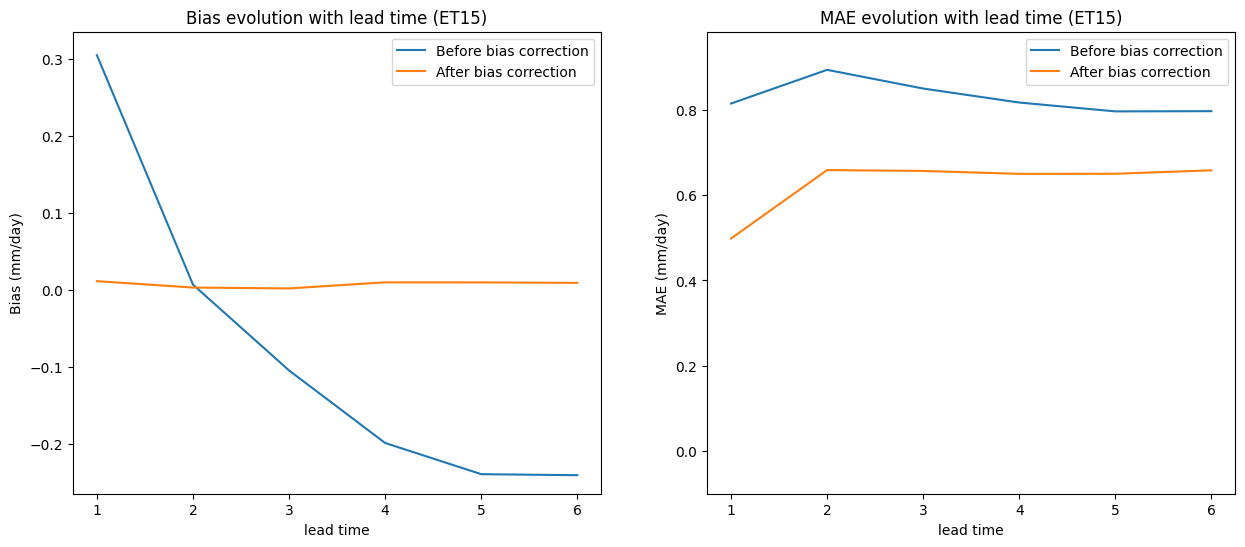

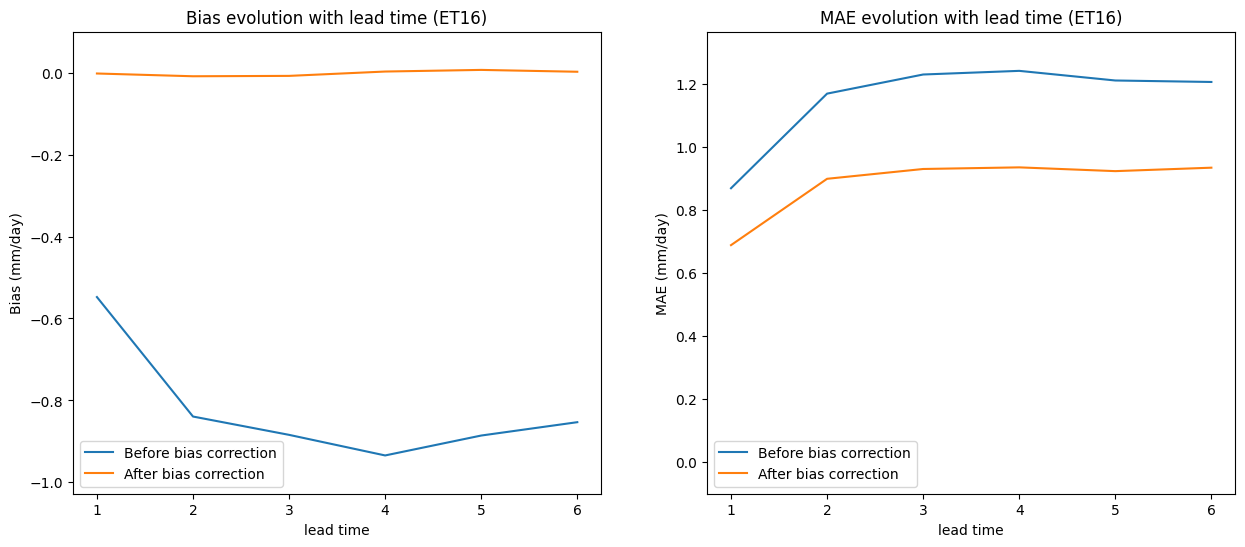

In [11]:
#month_range = [7,8,9]
month_range = [1,2,3,4,5,6,7,8,9,10,11,12]

for adm_pcode in ecmwf_adm_df['adm_pcode'].unique():
    plot_leadtime_month_dependency(ecmwf_adm_df[ecmwf_adm_df['adm_pcode'] == adm_pcode], ecmwf_corr_adm_df[ecmwf_corr_adm_df['adm_pcode'] == adm_pcode], month_range, scope_text = adm_pcode)   


## ROC / AUC analysis

In [12]:
score_df = ecmwf_adm_df
score_corr_df = ecmwf_corr_adm_df

month_range = [7,8,9]
score_df = ecmwf_adm_df[(ecmwf_adm_df.climatology_q50 > 0) & (ecmwf_adm_df['valid_time_month'].isin(month_range))]
score_corr_df = ecmwf_corr_adm_df[(ecmwf_corr_adm_df.climatology_q50 > 0) & (ecmwf_corr_adm_df['valid_time_month'].isin(month_range))]

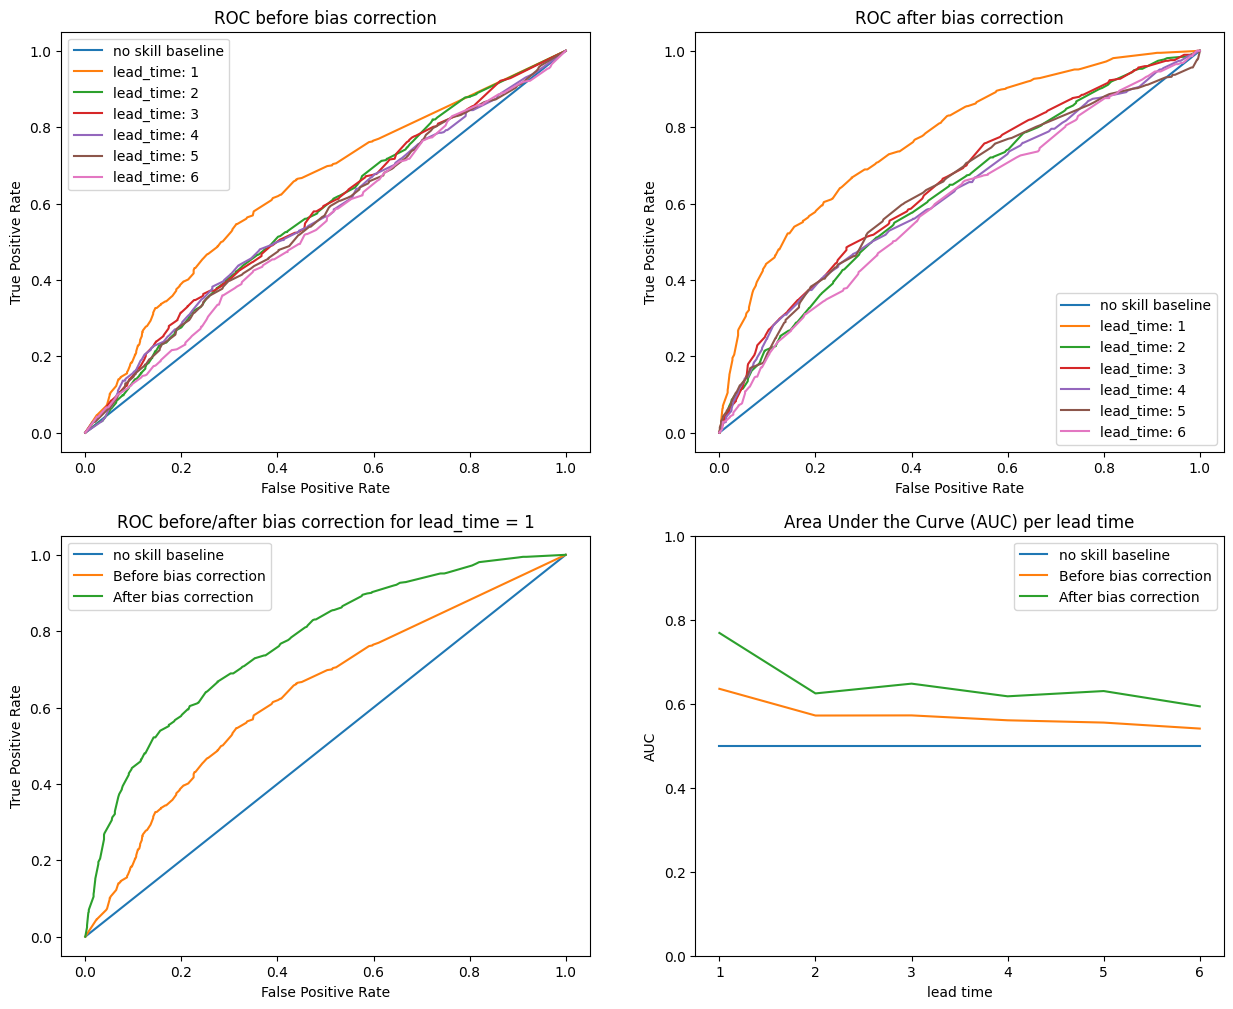

In [13]:
plot_roc_auc_analysis(score_df, score_corr_df, quantile_value = 33)

## Visualisation Sandbox

In [14]:
admin_df = gpd.read_file(admin_boundary_file_path)[[admin_code_label, 'geometry']]
admin_df.rename(columns = {admin_code_label : 'adm_pcode'}, inplace = True)

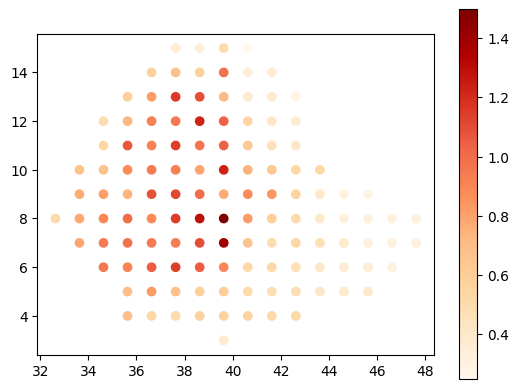

In [15]:
df = ecmwf_corr_pixel_df.groupby(['latitude','longitude'])['mae'].mean().reset_index()
score_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

score_df.plot(column="mae", legend=True, cmap='OrRd');

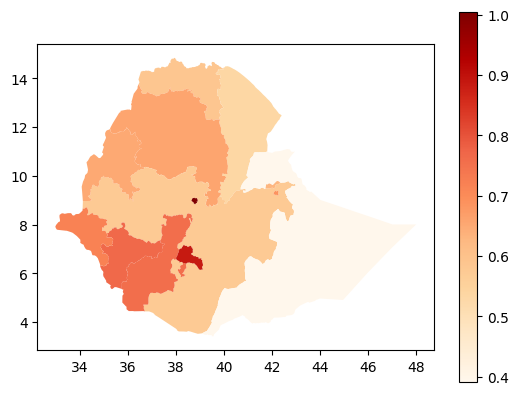

In [16]:
df = ecmwf_corr_adm_df.groupby('adm_pcode')['mae'].mean().reset_index()
score_df = gpd.GeoDataFrame(pd.merge(df, admin_df, on='adm_pcode'))
score_df.plot(column="mae", legend=True, cmap='OrRd');